In [241]:
# Not all of these will be used, remove as needed
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt, wiener
from scipy.ndimage import uniform_filter, variance, generic_filter
from scipy.fftpack import fft2, ifft2, fftshift
from tqdm import tqdm
from skimage import io, filters, morphology
from skimage.util import img_as_ubyte
from skimage.filters import rank, sobel
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
import heapq
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [27]:
file_directory = '/Users/moose/Desktop/trace_ca-local/Computed_Results'
folder_list = os.listdir(file_directory)
folder_list = [x for x in folder_list if x != '.DS_Store']

In [28]:
# Pull image paths

images = {}
for folder in folder_list:
    image_list = os.listdir(file_directory + '/' + folder)
    image_list = [x for x in image_list if x.endswith('.tif')]
    for i in range(len(image_list)):
        image_list[i] = io.imread(file_directory + '/' + folder + '/' + image_list[i])
    images[folder] = image_list


In [29]:
images.keys()

dict_keys(['Nonporous', 'DNAse', 'WT', 'PBP4'])

In [39]:
def edge_density(image):
    edges = sobel(image)
    return edges.mean()

In [40]:
edges = {}
for key in images.keys():
    edges_list = np.zeros(len(images[key]))
    for i in range(len(images[key])):
        edges_list[i] = edge_density(images[key][i])
    edges[key] = edges_list

In [55]:
for key in edges.keys():
    print(key)
    print(edges[key].mean())
    print(edges[key].std())
    print('-----------------')

Nonporous
0.0005377413996668687
3.9853735985656696e-05
-----------------
DNAse
0.00032047678846348443
1.9845539399925442e-05
-----------------
WT
0.00032070225758451445
3.0992906068225044e-05
-----------------
PBP4
0.0002930694170916032
4.979351693523604e-05
-----------------


In [262]:
# colors = ['Black', 'Orange', 'Cyan', 'Salmon']
# darker_colors = ['Dark' + color if color != 'Black' else 'Black' for color in colors]
# fig, ax = plt.subplots(dpi=300)
# for i, key in enumerate(edges.keys()):
#     ax.bar(key, edges[key].mean(), yerr = edges[key].std(), capsize = 10, alpha = 0.75, color=colors[i], width = 0.65, edgecolor = 'Black')
#     for j in range(len(edges[key])):
#         ax.scatter(key, edges[key][j], color = darker_colors[i], edgecolor = 'Black', s = 15)
# plt.show()

F-statistic: 86.14106331675137, P-value: 1.7146963071901388e-16


/var/folders/p0/tb_jc0zs6z383snrfzw6d5_00000gn/T/ipykernel_55309/2847189020.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  significant_comparisons['distance'] = significant_comparisons.apply(lambda row: abs(groups.index(row['group1']) - groups.index(row['group2'])), axis=1)


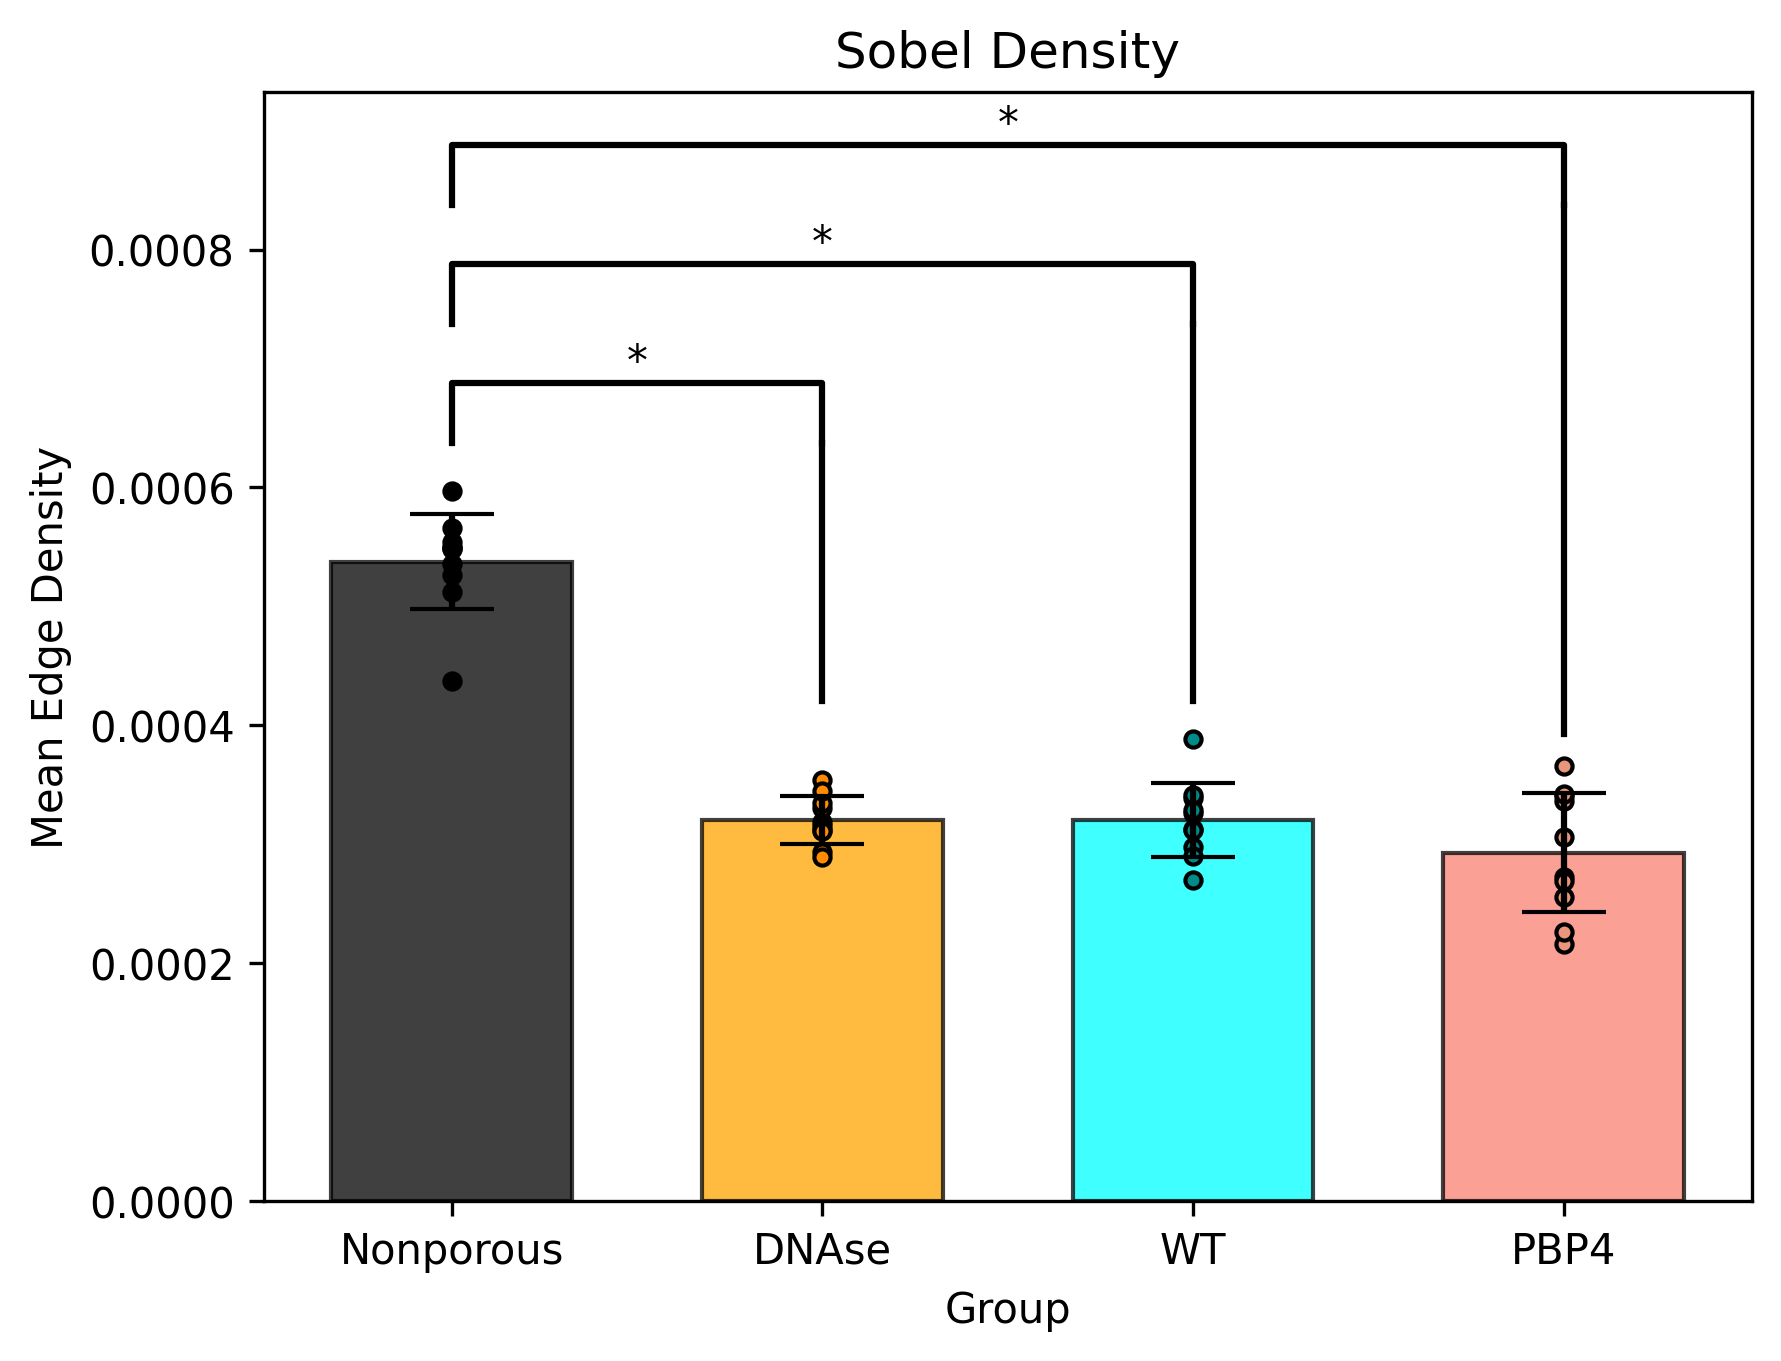

In [309]:
# Such a janky way to make a graph, maybe we should just stick to Prism? Or try seaborn?

anova_groups = [edges[key] for key in edges.keys()]

# One-way ANOVA
anova_result = f_oneway(*anova_groups)
print(f"F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}")

# Tukey HSD
tukey_values = np.concatenate(anova_groups) 
tukey_labels = np.concatenate([[key] * len(edges[key]) for key in edges.keys()])  
tukey_result = pairwise_tukeyhsd(tukey_values, tukey_labels)

groups = [key for key in edges.keys()]
means = [edges[key].mean() for key in edges.keys()]  

# Convert the tukey hsd results to a df
tukey_df = pd.DataFrame(data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0])
# Filter out significant comparisons
significant_comparisons = tukey_df[tukey_df['reject'] == True]

colors = ['Black', 'Orange', 'Cyan', 'Salmon']
darker_colors = ['Dark' + color if color != 'Black' else 'Black' for color in colors]
fig, ax = plt.subplots(dpi=300)
for i, key in enumerate(edges.keys()):
    ax.bar(key, edges[key].mean(), yerr = edges[key].std(), capsize = 10, alpha = 0.75, color=colors[i], width = 0.65, edgecolor = 'Black')
    for j in range(len(edges[key])):
        ax.scatter(key, edges[key][j], color = darker_colors[i], edgecolor = 'Black', s = 15)

y_offset = 0 
# Calculate the distance between groups for each comparison, used to sort signficance bars from closest group to farthest
significant_comparisons['distance'] = significant_comparisons.apply(lambda row: abs(groups.index(row['group1']) - groups.index(row['group2'])), axis=1)
significant_comparisons_sorted = significant_comparisons.sort_values(by='distance')

y_offset = 0 
for index, row in significant_comparisons_sorted.iterrows():
    group1, group2 = row['group1'], row['group2']
    x1, x2 = groups.index(group1), groups.index(group2)

    sorter = [(group1, x1), (group2, x2)] # Needed to reorganize groups so significance lines are drawn correctly...
    if sorter[0][1] > sorter[1][1]:
        sorter = sorter[::-1]
        group1, x1 = sorter[0]
        group2, x2 = sorter[1]

    mean1, mean2 = means[x1], means[x2]
    base_y = max(mean1, mean2) + 0.0001  # Base y-position for the significance line
    y = max(base_y, y_offset)  # Adjust y-position based on offset to avoid overlap
    h, col = 0.00005, 'Black'  # Height and color of the significance marker
    
    # Draw horizontal line for significance
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
    # Add significance marker "*", haven't figured out how to change based on p value, probably a list taken from the df?
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col)
    
    # Draw vertical lines down to the bars
    # plt.plot([x1, x1], [y, mean1], lw=1.5, c=col, linestyle='solid')  # Line down to group1 bar, not needed
    plt.plot([x2, x2], [y, mean2+0.0001], lw=1.5, c=col, linestyle='solid')  # Line down to group2 bar
    
    y_offset = y + h + 0.00005  # Increment y_offset for the next line so significance bars don't overlap

ax.set_xticks(range(len(groups)))
ax.set_xticklabels(groups)
plt.title('Sobel Density')
plt.xlabel('Group')
plt.ylabel('Mean Edge Density')
plt.show()
